In [1]:
from fastprogress import master_bar, progress_bar
# This will prompt for authorization.


In [2]:
# !pip install fastprogress

In [2]:
import os 

#first put a shortcut in your drive to the image processing folder

DATA_DIR = 'D:\\CalcificationDetection\\dataset'

PATCHES_DIR_1 = "D:\\CalcificationDetection\\Patches"
PATCHES_DIR = "J:\\.shortcut-targets-by-id\\1X3JbrfZbPs0AMWFj_sLDSIkzqHVjU8yp\\Results\\Patches"


RESULTS_DIR = "D:\\CalcificationDetection\\Results"




print(os.listdir(DATA_DIR))

# patches_file = os.listdir(PATCHES_DIR)

# print(len(patches_file))

['groundtruths', 'images', 'masks', 'normals.txt']


In [3]:
already = os.listdir(PATCHES_DIR_1)
print(len(os.listdir(PATCHES_DIR_1)))

411


In [13]:
already = [i for i in already if i != 'Results_csv']
len(already)

410

In [14]:
already = already[119:]
already

['22670832',
 '22670855',
 '22670878',
 '22670978',
 '22671003',
 '22678449',
 '22678472',
 '22678495',
 '22678518',
 '22678622',
 '22678646',
 '22678670',
 '22678694',
 '22678787',
 '22678810',
 '22678833',
 '22678856',
 '22678953',
 '22678980',
 '22679008',
 '22679036',
 '24054997',
 '24055024',
 '24055051',
 '24055078',
 '24055149',
 '24055176',
 '24055203',
 '24055274',
 '24055328',
 '24055355',
 '24055382',
 '24055445',
 '24055464',
 '24055483',
 '24055502',
 '24055573',
 '24055600',
 '24055627',
 '24055654',
 '24055725',
 '24055752',
 '24055779',
 '24055806',
 '24055877',
 '24055904',
 '24055931',
 '24055958',
 '24058660',
 '24058686',
 '24058712',
 '24058738',
 '24065251',
 '24065270',
 '24065289',
 '24065308',
 '24065380',
 '24065407',
 '24065434',
 '24065461',
 '24065530',
 '24065557',
 '24065584',
 '24065611',
 '24065680',
 '24065707',
 '24065734',
 '24065761',
 '24065833',
 '24065860',
 '24065887',
 '24065914',
 '26933772',
 '26933801',
 '26933830',
 '26933859',
 '27829134',

In [4]:
already = []
len(already)

0

In [5]:
import numpy as np
import pandas as pd
import os
import cv2

In [6]:
def sliding_window(image, stepSize, windowSize, groundTruth, mask):
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]], str(int(np.sum(groundTruth[y:y + windowSize[1], x:x + windowSize[0]])>0)), str(int(np.sum(mask[y:y + windowSize[1], x:x + windowSize[0]])==0)))

In [7]:
def patchExtraction(centroid, image, windowSize):


    # candidates are y,x and sigma
    left = int(centroid[1] - (windowSize/2)) 
    right = int(centroid[1] + (windowSize/2) - 1)
    top = int(centroid[0] - (windowSize/2))
    bottom = int(centroid[0] + (windowSize/2) - 1)

    patchCandidate = image[left: right,
                            top : bottom]
    
    return patchCandidate

In [8]:
#import plt for display
import matplotlib.pyplot as plt

#go into de directory of the images

# this have 3 outputs root directory, the folders in the path and the files in the path.
# we ignore _ the two first because we are not interested in those
_, _, images = next(os.walk(os.path.join(DATA_DIR,'images')))
_, _, breastMasks = next(os.walk(os.path.join(DATA_DIR,'masks')))
_, _, groundTruths = next(os.walk(os.path.join(DATA_DIR, 'groundtruths')))

images.sort()
breastMasks.sort()
groundTruths.sort()

# read numbers of normal images
normals = []
with open(os.path.join(DATA_DIR,'normals.txt')) as f:
    for line in f:
        normals.append(line[:-1])

In [9]:
print(len(already))

0


In [10]:
import copy
import pandas as pd
import time
import gc

groundTruthsDataFrame = pd.read_csv(os.path.join(RESULTS_DIR,'groundTruthStats.csv'))

groundTruthsDataFrame['key']= [i.split('_')[0] for i in groundTruthsDataFrame['name'].values.tolist()]

row_centroids = []
for index, row in groundTruthsDataFrame.iterrows():
    centroids = []
    for key, value in eval(row['centroids']).items():
        if key == 0:
            continue
        x = round(value['x'])
        y = round(value['y'])
        centroid = (x, y)
        centroids.append(centroid)
    row_centroids.append(centroids)

groundTruthsDataFrame['tuple_centroids'] = row_centroids

windowsWH = [24,48,96]

for w in windowsWH:

    winW=w
    winH=w

    # already = []

    for image, breastMask, groundTruth in zip(progress_bar(images), breastMasks, groundTruths):
        start = time.time()

        patch_name_label_list = []

        count_neg = 0
        count_pos = 0
        count_bkg = 0


        # 20588020, 7717, 5328, 3787, 5725, 3859, 6934, 50995872
        # digits = '20587372'

        # if ((digits in image) and (digits in breastMask) and ('mask' in breastMask)):
        if image.split('_')[0] not in already:

            imageKey = image.split('_')[0]

            new_path = os.path.join(PATCHES_DIR, imageKey) 
            if not os.path.exists(new_path):
                os.mkdir(new_path)
                print("Directory " , new_path ,  " Created ")
            else:    
                print("Directory " , new_path ,  " already exists")    

            new_path = os.path.join(PATCHES_DIR, imageKey, str(winW)) 
            if not os.path.exists(new_path):
                os.mkdir(new_path)
                print("Directory " , new_path ,  " Created ")
            else:    
                print("Directory " , new_path ,  " already exists. Skiping")
                continue

            #if image not in already:
            print("image: ", image)
            #upload images
            img = cv2.imread(os.path.join(DATA_DIR,'images',image))
            imgMask = cv2.imread(os.path.join(DATA_DIR, 'masks', breastMask), cv2.IMREAD_GRAYSCALE)
            imgGroundTruth = cv2.imread(os.path.join(DATA_DIR, 'groundtruths', image), cv2.IMREAD_GRAYSCALE)


            # imgCopy = copy.deepcopy(img)
            # imgCopy = cv2.cvtColor(imgCopy, cv2.COLOR_BGR2GRAY)


            gtRow = groundTruthsDataFrame.loc[groundTruthsDataFrame['key'] == image.split('_')[0]]


            for centroid in gtRow['tuple_centroids'].values[0]:
                if ((centroid[1]+(winW/2)) < img.shape[0]) and ((centroid[0]+(winW/2)) < img.shape[1]) and ((centroid[1]-(winW/2)) > 0) and ((centroid[0]-(winW/2)) > 0):
                    file_name = imageKey+'_'+str(winW)+'_P_'+str(count_pos)+'.tif'
                    window = patchExtraction(centroid, img, winW)
                    result = cv2.imwrite(os.path.join(PATCHES_DIR, imageKey, str(winW), file_name), window)
                    count_pos += 1 
                    print("Positive patch ready ", result)

                    patch_name_label_list.append([file_name, '1'])



            for (x, y, window, label, background) in sliding_window(img, stepSize=int(winW/3)*2, windowSize=(winW, winH), groundTruth=imgGroundTruth, mask=imgMask):
                if window.shape[0] != winH or window.shape[1] != winW:
                    continue

                if bool(int(background)):
                    count_bkg += 1
                    continue

                if label == '0':
                    file_name = imageKey+'_'+str(winW)+'_N_'+str(count_neg)+'.tif'
                    result = cv2.imwrite(os.path.join(PATCHES_DIR,  imageKey, str(winW), file_name), window) 
                    count_neg += 1
                    patch_name_label_list.append([file_name, label])


            print('Number of backgrounds ignored: ', count_bkg)
            print('Number of positives: ', count_pos)
            print('Number of negatives: ', count_neg)

            df = pd.DataFrame(patch_name_label_list, columns=['patchName', 'label'])


            # if(flag):
            df.to_csv(os.path.join(PATCHES_DIR_1,
                                   'Results_csv',
                                   str(winW),
                                   imageKey+'_patches_P_{}_N_{}.csv'.format(count_pos, count_neg)),
                            index=False)


            del df, img, imgMask, window
            gc.collect()

            print("Time taken for the image: ", time.time() - start)
            #   flag = False
            # else:
            #   df.to_csv(os.path.join('/content',
            #                               'drive',
            #                               'MyDrive',
            #                               'Results',
            #                               'X_train3.csv'),
            #                 mode='a',
            #                 header=False,
            #                 index=False)

              # machine learning must be applied for the classification of the features extracted



Directory  J:\.shortcut-targets-by-id\1X3JbrfZbPs0AMWFj_sLDSIkzqHVjU8yp\Results\Patches\20586908  already exists
Directory  J:\.shortcut-targets-by-id\1X3JbrfZbPs0AMWFj_sLDSIkzqHVjU8yp\Results\Patches\20586908\24  already exists. Skiping
Directory  J:\.shortcut-targets-by-id\1X3JbrfZbPs0AMWFj_sLDSIkzqHVjU8yp\Results\Patches\20586934  already exists
Directory  J:\.shortcut-targets-by-id\1X3JbrfZbPs0AMWFj_sLDSIkzqHVjU8yp\Results\Patches\20586934\24  Created 
image:  20586934_6c613a14b80a8591_MG_L_CC_ANON.tif
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Po

Number of backgrounds ignored:  18329
Number of positives:  6
Number of negatives:  14536
Time taken for the image:  1204.4930324554443
Directory  J:\.shortcut-targets-by-id\1X3JbrfZbPs0AMWFj_sLDSIkzqHVjU8yp\Results\Patches\20587346  already exists
Directory  J:\.shortcut-targets-by-id\1X3JbrfZbPs0AMWFj_sLDSIkzqHVjU8yp\Results\Patches\20587346\24  Created 
image:  20587346_e634830794f5c1bd_MG_R_ML_ANON.tif
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Number of backgrounds ignored:  17108
Number of positives:  3
Number of negatives:  15797
Time taken for the image:  1065.4937596321106
Directory  J:\.shortcut-targets-by-id\1X3JbrfZbPs0AMWFj_sLDSIkzqHVjU8yp\Results\Patches\20587372  already exists
Directory  J:\.shortcut-targets-by-id\1X3JbrfZbPs0AMWFj_sLDSIkzqHVjU8yp\Results\Patches\20587372\24  already exists. Skiping
Directory  J:\.shortcut-targets-by-id\1X3JbrfZbPs0AMWFj_sLDSIkzqHVjU8yp\Results\Patches\20587466  already exists
Directory  J:\.shortcu

Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
P

Positive patch ready  True
Positive patch ready  True
Number of backgrounds ignored:  30641
Number of positives:  104
Number of negatives:  21611
Time taken for the image:  1923.526850938797
Directory  J:\.shortcut-targets-by-id\1X3JbrfZbPs0AMWFj_sLDSIkzqHVjU8yp\Results\Patches\20587690  already exists
Directory  J:\.shortcut-targets-by-id\1X3JbrfZbPs0AMWFj_sLDSIkzqHVjU8yp\Results\Patches\20587690\24  Created 
image:  20587690_f4b2d377f43ba0bd_MG_L_ML_ANON.tif
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Positive patch ready  

Directory  J:\.shortcut-targets-by-id\1X3JbrfZbPs0AMWFj_sLDSIkzqHVjU8yp\Results\Patches\20588334\24  Created 
image:  20588334_493155e17143edef_MG_L_CC_ANON.tif
Number of backgrounds ignored:  26625
Number of positives:  0
Number of negatives:  6288
Time taken for the image:  532.4138724803925
Directory  J:\.shortcut-targets-by-id\1X3JbrfZbPs0AMWFj_sLDSIkzqHVjU8yp\Results\Patches\20588458  Created 
Directory  J:\.shortcut-targets-by-id\1X3JbrfZbPs0AMWFj_sLDSIkzqHVjU8yp\Results\Patches\20588458\24  Created 
image:  20588458_bf1a6aaadb05e3df_MG_R_CC_ANON.tif
Positive patch ready  True
Positive patch ready  True
Positive patch ready  True
Number of backgrounds ignored:  20833
Number of positives:  3
Number of negatives:  12068
Time taken for the image:  1111.2215554714203
Directory  J:\.shortcut-targets-by-id\1X3JbrfZbPs0AMWFj_sLDSIkzqHVjU8yp\Results\Patches\20588510  Created 
Directory  J:\.shortcut-targets-by-id\1X3JbrfZbPs0AMWFj_sLDSIkzqHVjU8yp\Results\Patches\20588510\24  Created 
ima

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'J:\\.shortcut-targets-by-id\\1X3JbrfZbPs0AMWFj_sLDSIkzqHVjU8yp\\Results\\Patches\\22427840'

In [ ]:
test_path = '/content/drive/MyDrive/Results/Patches/20587372/24/'
if not os.path.exists(test_path):
  os.mkdir(test_path)
else:
  print('existe')

In [ ]:
df.to_csv( '/content/drive/MyDrive/'+'20586908'+'_patches'+'_P_{}_N_{}.csv'.format(39, 323200),
          mode='a',
          index=False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

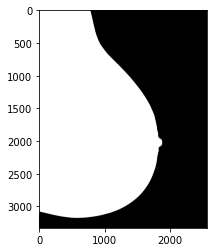

In [ ]:

 
point_size = 1
point_color = (0, 0, 255) # BGR
espesor = 4 # puede ser 0, 4, 8
 
 # Las coordenadas del punto a dibujar
points_list = gtRow['tuple_centroids'].values[0]
 
for point in points_list:
	cv2.circle(imgGroundTruth, point, point_size, point_color, espesor)
 
 # Dibuja un círculo, el centro es: (160, 160), el radio es: 60, el color es: point_color, línea sólida

plt.imshow(imgGroundTruth, cmap='gray')
plt.imshow(imgMask, cmap='gray')

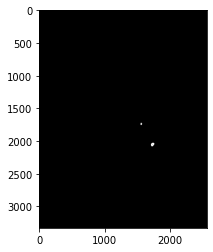

In [ ]:
plt.imshow(imgGroundTruth, cmap='gray')

In [ ]:
imgGroundTruth.shape

(3328, 2560)

In [ ]:
imgMask = cv2.imread(os.path.join(DATA_DIR, 'masks', breastMasks[0]), cv2.IMREAD_GRAYSCALE)

imgMask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
eval(gtRow['centroids'].values[0])

{0: {'x': 1279.364551254805, 'y': 1663.396357108136},
 1: {'x': 1557.704579025111, 'y': 1738.128508124077},
 2: {'x': 1729.9216052263182, 'y': 2051.82874475035}}

In [ ]:
gtRow['tuple_centroids'].values[0]

[(1558, 1738), (1730, 2052)]

In [ ]:
ret, binary = cv2.threshold(imgMask, 0, 256, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
print("threshold：%s" % ret)


threshold：0.0


In [ ]:
np.sum(binary[12:24, 12:24])

0

In [ ]:
sum(sum(imgGroundTruth))

81179

In [ ]:
np.sum(imgGroundTruth)

580635

In [ ]:
from matplotlib.patches import Circle
import matplotlib.patches as mpatches

# function to draw the grid to display
def display_grid(figure, axis, img, imgGroundTruth, preprocessed, candidates, features):
  # draw in the axis the img
  axis[0][0].imshow(img)
  # switch off the axis of the plot
  axis[0][0].axis('off')
  # set a title for the plot
  axis[0][0].set_title('Image')

  axis[0][1].imshow(imgGroundTruth, cmap='gray')
  axis[0][1].axis('off')
  axis[0][1].set_title('Ground Truth')

  axis[0][2].imshow(imgMask)
  axis[0][2].axis('off')
  axis[0][2].set_title('Breast Mask')

  axis[1][0].imshow(preprocessed, cmap='gray')
  rec = cv2.rectangle(preprocessed, pt1=(candidates[0][1],candidates[0][0]), pt2=(candidates[0][1]+12,candidates[0][0]+12), color=(0,0,255), thickness=-1)
  axis[1][0].add_patch(rec)
  axis[1][0].axis('off')
  axis[1][0].set_title('Preprocessed')

  # draw candidates as circles
  axis[1][1].imshow(preprocessed, cmap='gray')

  axis[1][1].axis('off')
  axis[1][1].set_title('Candidates')

  # Now, loop through coord arrays, and create a circle at each x,y pair
  for x,y in candidates:

    blob = Circle((x,y), 5, color='blue', fill=False)
    axis[1][1].add_patch(blob)

    rect=mpatches.Rectangle((x,y),12,12, 
                        fill=False,
                        color="red",
                       linewidth=2)
    axis[1][1].add_patch(rect)

  
  
  axis[1][2].imshow(imgGroundTruth, cmap='gray')
  axis[1][2].axis('off')
  axis[1][2].set_title('compare with ground truth and candidates')

  # Now, loop through coord arrays, and create a circle at each x,y pair
  for x,y in candidates:
    blob = Circle((x,y), 5, color='blue', fill=False)
    axis[1][2].add_patch(blob)
  
  return figure, axis


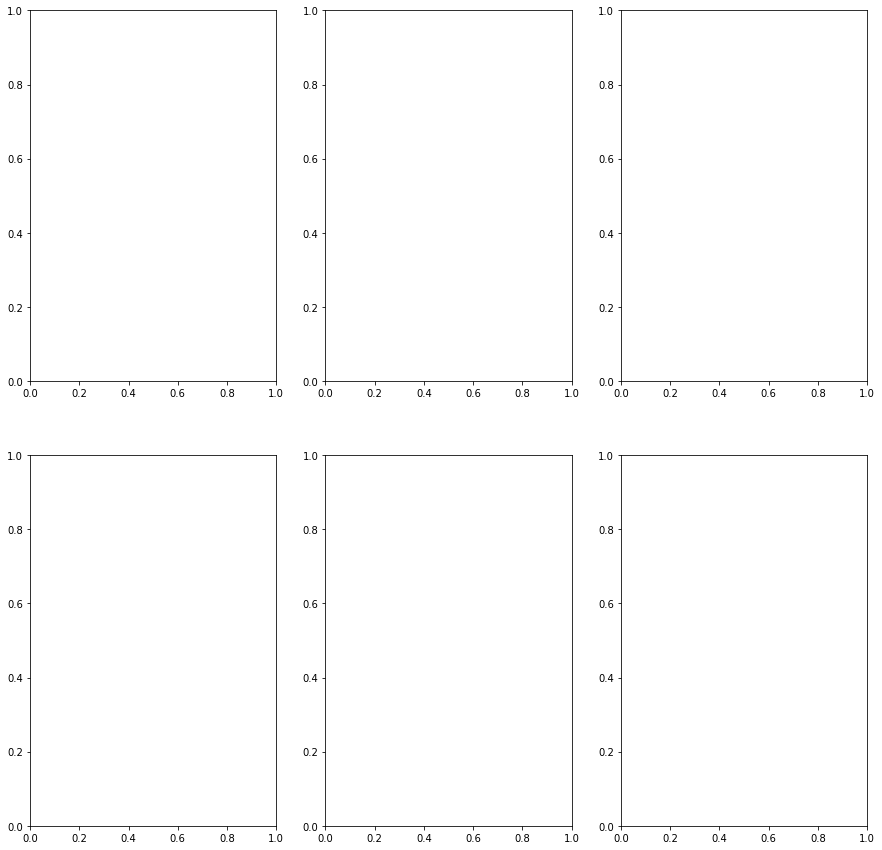

AttributeError: ignored

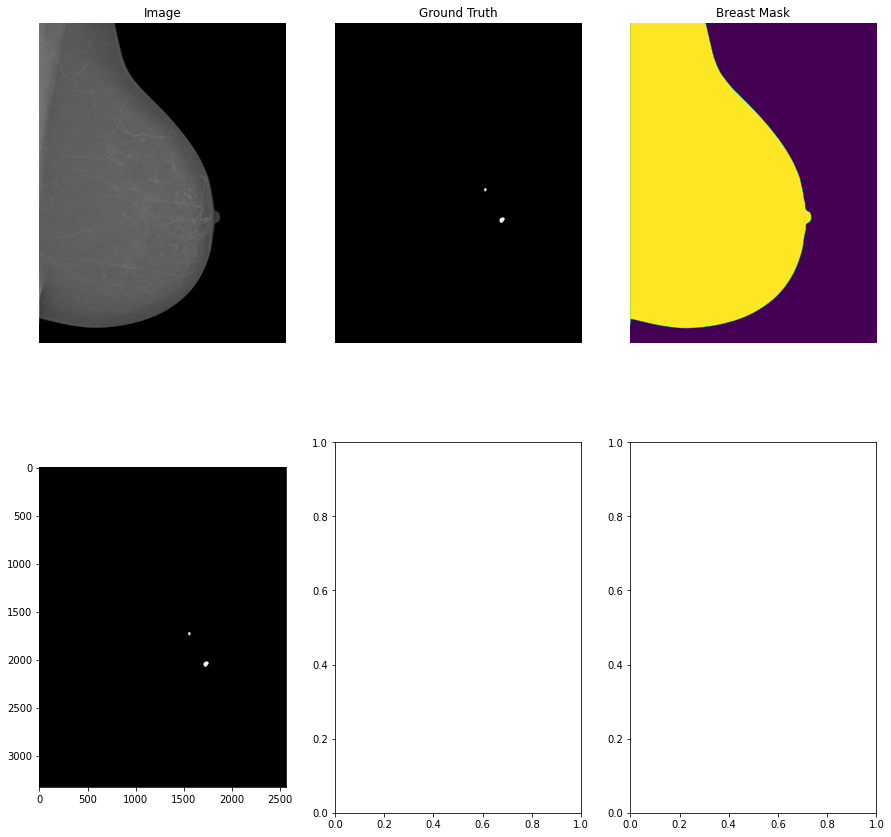

In [ ]:
figure, axis = plt.subplots(2, 3, figsize=(15,15))
display_grid(figure, axis, img, imgGroundTruth, imgGroundTruth, gtRow['tuple_centroids'].values[0], None)
plt.subplots_adjust(wspace=0, hspace=0)

# display figure with image
plt.show()
